In [1]:
!pip install pyspark

In [2]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Kaggle Spark") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/06 14:28:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

In [5]:
df_ecom_part=spark.read.parquet('/kaggle/input/user-partitioned-data/df_ecom_part_parquet')
df_ecom_part.show(5)

+-------------------+----------+----------+-------------------+--------------------+-------+-----+---------+--------------------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand|price|  user_id|        user_session|user_partition_group|
+-------------------+----------+----------+-------------------+--------------------+-------+-----+---------+--------------------+--------------------+
|2019-10-02 11:48:09|      view|   4501766|2053013563877884791|appliances.kitche...|  midea|92.64|513996137|0bb21328-fbba-46f...|                   0|
|2019-10-01 16:59:10|      view|   6200523|2053013552293216471|appliances.enviro...|timberk|64.32|515182686|08fab88e-0121-446...|                   0|
|2019-10-02 11:48:15|      view|   7900440|2053013556487520725|furniture.kitchen...|  selby|43.73|555994208|59366a8c-be9e-48e...|                   0|
|2019-10-01 16:59:10|      view|   3800548|2053013566176363511|     appliances.iron|  vitek|28

In [6]:
df=spark.read.csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv',header=True,inferSchema=True)

In [ ]:
df_ecom_part=spark.read.parquet('/kaggle/input/user-partitioned-data/df_ecom_part_parquet')
df_ecom_part.show(5)

In [7]:
df.show(5,False)

+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|event_time         |event_type|product_id|category_id        |category_code                      |brand   |price  |user_id  |user_session                        |
+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|2019-10-01 00:00:00|view      |44600062  |2103807459595387724|NULL                               |shiseido|35.79  |541312140|72d76fde-8bb3-4e00-8c23-a032dfed738c|
|2019-10-01 00:00:00|view      |3900821   |2053013552326770905|appliances.environment.water_heater|aqua    |33.2   |554748717|9333dfbd-b87a-4708-9857-6336556b0fcc|
|2019-10-01 00:00:01|view      |17200506  |2053013559792632471|furniture.living_room.sofa         |NULL    |543.1  |519107250|566511c2-e2e3-422b-b695-cf8e6e792ca8|
|2019-10-01 00:0

In [8]:
df.count()

42448764

In [10]:
df_ecom=df.filter((col('category_code').isNotNull() & (col('brand').isNotNull())))

In [11]:
df_ecom.count()

26560622

In [12]:
df_ecom.where((col('category_code').isNull()) | (col('brand').isNull())).count()

0

In [13]:
df_part=df_ecom.withColumn('user_partition_group',hash(col('user_id'))%100)
df_part.repartition(100,'user_partition_group')
df_part.write.mode('overwrite').partitionBy('user_partition_group').parquet('/kaggle/working/user_partition/')

In [14]:
df_ecom.show()

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:04|      view|   1004237|2053013555631882655|electronics.smart...|   apple|1081.98|535871217|c6bd7419-2748-4c5...|
|2019-10-01 00:00:05|      view|   1480613|2053013561092866779|   computers.desktop|  pulser| 908.62|512742880|0d0d91c2-c9c2-4e8...|
|2019-10-01 00:00:10|      view|  28719074|2053013565480109009|  appa

In [15]:
df_ecom_part=spark.read.parquet('/kaggle/working/user_partition/',inferSchema=True)
df_ecom_part.count()

26560622

# User analysis

In [16]:
user_event_cnt=df_ecom_part.groupBy('user_id','event_type').agg(count('*').alias('event_cnt'))
user_event_cnt.show(5,False)

+---------+----------+---------+
|user_id  |event_type|event_cnt|
+---------+----------+---------+
|517682460|view      |6        |
|515587866|view      |1        |
|542333098|view      |1        |
|519705698|view      |40       |
|513790618|view      |22       |
+---------+----------+---------+
only showing top 5 rows



In [18]:
df_ecom_part.printSchema

<bound method DataFrame.printSchema of DataFrame[event_time: timestamp, event_type: string, product_id: int, category_id: bigint, category_code: string, brand: string, price: double, user_id: int, user_session: string, user_partition_group: int]>

In [19]:
user_event_pivot= user_event_cnt.groupBy('user_id').pivot('event_type',['view','cart','purchase']).sum('event_cnt').na.fill(0)
user_event_pivot.show(5,False)

+---------+----+----+--------+
|user_id  |view|cart|purchase|
+---------+----+----+--------+
|517682460|6   |1   |2       |
|519705698|40  |0   |0       |
|515406162|173 |0   |0       |
|523367237|46  |1   |1       |
|527916573|20  |3   |0       |
+---------+----+----+--------+
only showing top 5 rows



In [20]:
user_event_pivot = user_event_pivot.withColumn(
                                            "view_to_cart_rate", when(col("view") == 0, 0).otherwise(col("cart") / col("view"))
                                        ).withColumn(
                                            "cart_to_purchase_rate", when(col("cart") == 0, 0).otherwise(col("purchase") / col("cart"))
                                        ).withColumn(
                                            "view_to_purchase_rate", when(col("view") == 0, 0).otherwise(col("purchase") / col("view"))
                                        )
user_event_pivot.show(5, truncate=False)

+---------+----+----+--------+--------------------+---------------------+---------------------+
|user_id  |view|cart|purchase|view_to_cart_rate   |cart_to_purchase_rate|view_to_purchase_rate|
+---------+----+----+--------+--------------------+---------------------+---------------------+
|517682460|6   |1   |2       |0.16666666666666666 |2.0                  |0.3333333333333333   |
|519705698|40  |0   |0       |0.0                 |0.0                  |0.0                  |
|515406162|173 |0   |0       |0.0                 |0.0                  |0.0                  |
|523367237|46  |1   |1       |0.021739130434782608|1.0                  |0.021739130434782608 |
|527916573|20  |3   |0       |0.15                |0.0                  |0.0                  |
+---------+----+----+--------+--------------------+---------------------+---------------------+
only showing top 5 rows



In [21]:
user_catg_behv = df_ecom_part.groupBy('user_id','category_code','event_type').agg(count('*').alias('user_catg_evnt_cnt'))
user_catg_behv.orderBy('user_id','user_catg_evnt_cnt',ascending=False).show(5,False)

+---------+---------------------------+----------+------------------+
|user_id  |category_code              |event_type|user_catg_evnt_cnt|
+---------+---------------------------+----------+------------------+
|566280697|electronics.camera.video   |view      |1                 |
|566280676|furniture.bedroom.bed      |view      |1                 |
|566280663|electronics.smartphone     |view      |2                 |
|566280422|auto.accessories.player    |view      |3                 |
|566280399|electronics.audio.headphone|view      |6                 |
+---------+---------------------------+----------+------------------+
only showing top 5 rows



In [22]:
user_brand_behv = df_ecom_part.groupBy("user_id", "brand", "event_type").agg(count("*").alias("event_count"))
user_brand_behv.orderBy("user_id", "event_count", ascending=False).show(10, truncate=False)

+---------+----------+----------+-----------+
|user_id  |brand     |event_type|event_count|
+---------+----------+----------+-----------+
|566280697|dji       |view      |1          |
|566280676|stendmebel|view      |1          |
|566280663|apple     |view      |2          |
|566280422|kenwood   |view      |3          |
|566280399|sony      |view      |2          |
|566280399|fender    |view      |1          |
|566280399|harper    |view      |1          |
|566280399|apple     |view      |1          |
|566280399|jbl       |view      |1          |
|566280378|magnetta  |view      |2          |
+---------+----------+----------+-----------+
only showing top 10 rows



In [23]:
user_catg_brand_behv= df_ecom_part.groupBy('user_id','category_code','brand','event_type').agg(count('*').alias('user_catg_brand_cnt'))
user_catg_brand_behv.orderBy('user_id','category_code','user_catg_brand_cnt',ascending=False).show(5,False)

+---------+---------------------------+----------+----------+-------------------+
|user_id  |category_code              |brand     |event_type|user_catg_brand_cnt|
+---------+---------------------------+----------+----------+-------------------+
|566280697|electronics.camera.video   |dji       |view      |1                  |
|566280676|furniture.bedroom.bed      |stendmebel|view      |1                  |
|566280663|electronics.smartphone     |apple     |view      |2                  |
|566280422|auto.accessories.player    |kenwood   |view      |3                  |
|566280399|electronics.audio.headphone|sony      |view      |2                  |
+---------+---------------------------+----------+----------+-------------------+
only showing top 5 rows



In [24]:
user_catg_brand_behv.filter((col('category_code')=='electronics.audio.headphone') & (col('event_type')=='purchase')).orderBy(col('user_catg_brand_cnt').desc()).show()

+---------+--------------------+-------+----------+-------------------+
|  user_id|       category_code|  brand|event_type|user_catg_brand_cnt|
+---------+--------------------+-------+----------+-------------------+
|514179041|electronics.audio...|  apple|  purchase|                 72|
|523272971|electronics.audio...|  apple|  purchase|                 47|
|530206193|electronics.audio...|  apple|  purchase|                 43|
|529306305|electronics.audio...|  apple|  purchase|                 40|
|516340491|electronics.audio...|  apple|  purchase|                 35|
|543953918|electronics.audio...| xiaomi|  purchase|                 34|
|552949638|electronics.audio...|  apple|  purchase|                 31|
|516993548|electronics.audio...|  apple|  purchase|                 29|
|516492996|electronics.audio...|    jbl|  purchase|                 27|
|540965270|electronics.audio...|  apple|  purchase|                 27|
|538648461|electronics.audio...|  apple|  purchase|             

In [25]:
w_brand_rank = Window.partitionBy('user_id','category_code','event_type').orderBy(col('user_catg_brand_cnt').desc())
user_top_brand_in_catg = user_catg_brand_behv.withColumn('rank',row_number().over(w_brand_rank)) #.filter(col('rank')==1)
user_top_brand_in_catg.orderBy('user_id','category_code','rank',ascending=False).show()

+---------+--------------------+----------+----------+-------------------+----+
|  user_id|       category_code|     brand|event_type|user_catg_brand_cnt|rank|
+---------+--------------------+----------+----------+-------------------+----+
|566280697|electronics.camer...|       dji|      view|                  1|   1|
|566280676|furniture.bedroom...|stendmebel|      view|                  1|   1|
|566280663|electronics.smart...|     apple|      view|                  2|   1|
|566280422|auto.accessories....|   kenwood|      view|                  3|   1|
|566280399|electronics.audio...|       jbl|      view|                  1|   5|
|566280399|electronics.audio...|    harper|      view|                  1|   4|
|566280399|electronics.audio...|     apple|      view|                  1|   3|
|566280399|electronics.audio...|    fender|      view|                  1|   2|
|566280399|electronics.audio...|      sony|      view|                  2|   1|
|566280378|construction.tool...|  magnet

In [26]:
user_top_brand_in_catg.filter((col('category_code')=='electronics.audio.headphone')  & (col('user_id')=='566280399') & (col('event_type') =='cart')).orderBy('rank',ascending=False).show(5,False)

+-------+-------------+-----+----------+-------------------+----+
|user_id|category_code|brand|event_type|user_catg_brand_cnt|rank|
+-------+-------------+-----+----------+-------------------+----+
+-------+-------------+-----+----------+-------------------+----+



In [27]:
user_top_brand_in_catg.filter(col('rank') >= 2).show()

+---------+--------------------+--------+----------+-------------------+----+
|  user_id|       category_code|   brand|event_type|user_catg_brand_cnt|rank|
+---------+--------------------+--------+----------+-------------------+----+
|240522111|electronics.audio...| samsung|      view|                  1|   2|
|265601964|electronics.smart...| samsung|      view|                  1|   2|
|277655927|appliances.enviro...| karcher|      view|                  6|   2|
|277655927|appliances.enviro...|   bosch|      view|                  3|   3|
|277655927|appliances.enviro...| philips|      view|                  2|   4|
|282977436|electronics.video.tv|    sony|      view|                  7|   2|
|282977436|electronics.video.tv| samsung|      view|                  2|   3|
|301573329|  computers.notebook|  lenovo|      view|                  1|   2|
|301573329|  computers.notebook|    asus|      view|                  1|   3|
|304501389|electronics.smart...|    vivo|      view|            

## Session Analysis

In [28]:
df_time=df_ecom_part.withColumn('event_hour',hour('event_time')) \
                    .withColumn('event_day',dayofweek('event_time'))
hourly_activity=df_time.groupBy('event_hour','event_type').agg(count('*').alias('event_hour_cnt')).orderBy(col('event_hour_cnt').desc())
hourly_activity.show(5,False)

+----------+----------+--------------+
|event_hour|event_type|event_hour_cnt|
+----------+----------+--------------+
|16        |view      |1820541       |
|15        |view      |1792304       |
|17        |view      |1619499       |
|14        |view      |1615637       |
|13        |view      |1420848       |
+----------+----------+--------------+
only showing top 5 rows



In [29]:
daily_activity=df_time.groupBy('event_day','event_type').agg(count('*').alias('event_day_cnt')).orderBy(col('event_day_cnt').desc())
daily_activity.show(5,False)

+---------+----------+-------------+
|event_day|event_type|event_day_cnt|
+---------+----------+-------------+
|3        |view      |4001579      |
|4        |view      |3937833      |
|5        |view      |3824316      |
|1        |view      |3481148      |
|6        |view      |3452381      |
+---------+----------+-------------+
only showing top 5 rows



In [30]:
hourly_pd=hourly_activity.toPandas()
daily_pd=daily_activity.toPandas()



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

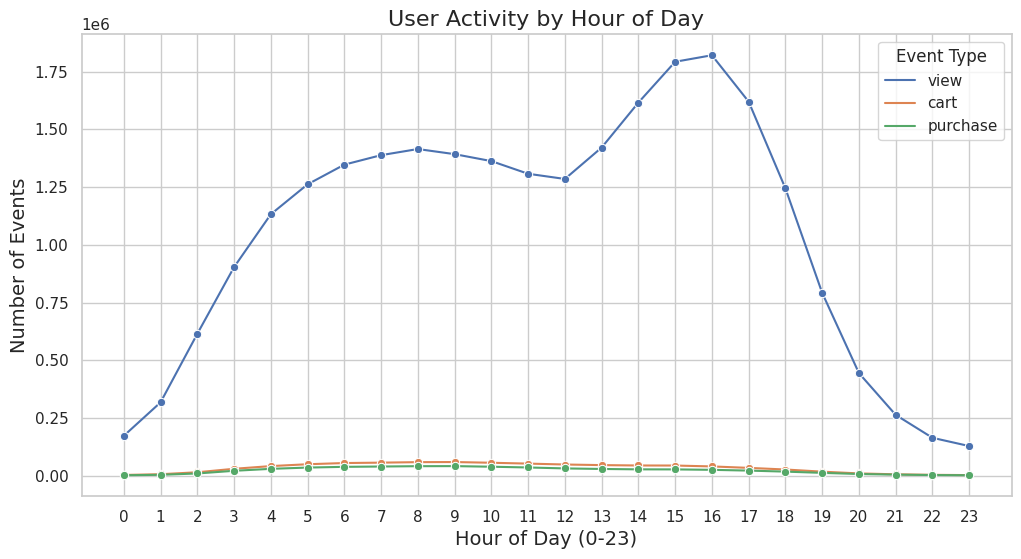

In [31]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_pd, x="event_hour", y="event_hour_cnt", hue="event_type", marker="o")
plt.title("User Activity by Hour of Day", fontsize=16)
plt.xlabel("Hour of Day (0-23)", fontsize=14)
plt.ylabel("Number of Events", fontsize=14)
plt.legend(title="Event Type")
plt.xticks(range(0,24))
plt.show()

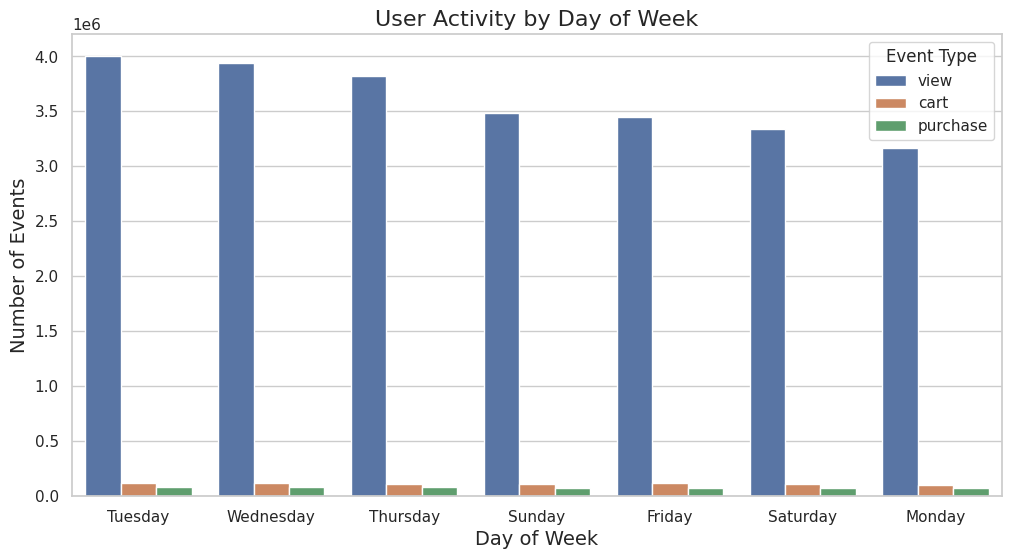

In [32]:
day_mapping = {
    1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday",
    5: "Thursday", 6: "Friday", 7: "Saturday"
}
daily_pd["day_name"] = daily_pd["event_day"].map(day_mapping)

plt.figure(figsize=(12,6))
sns.barplot(data=daily_pd, x="day_name", y="event_day_cnt", hue="event_type")
plt.title("User Activity by Day of Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=14)
plt.ylabel("Number of Events", fontsize=14)
plt.legend(title="Event Type")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

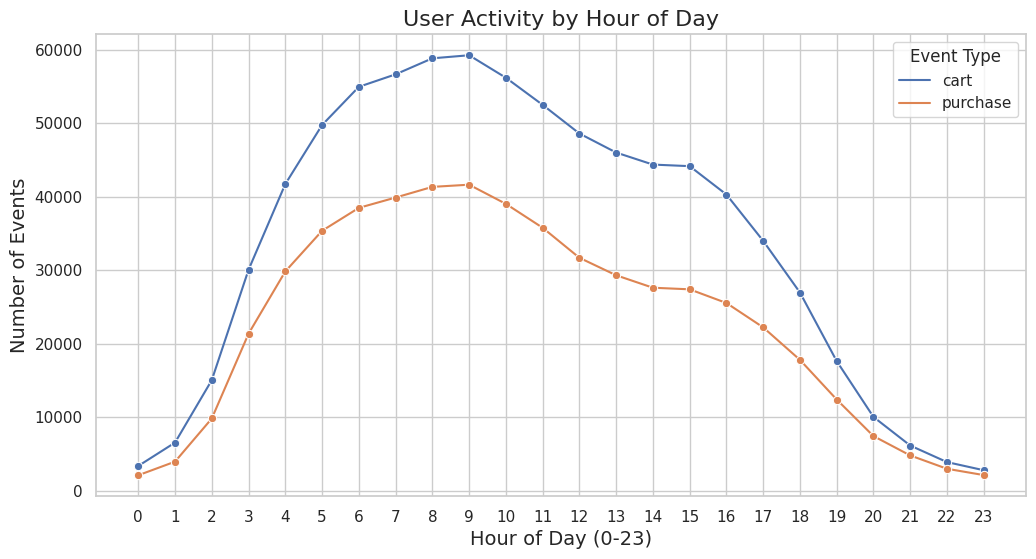

In [33]:
hourly_activity_filtered=hourly_activity.filter(col('event_type') != 'view')
hourly_filtered_pd=hourly_activity_filtered.toPandas()

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_filtered_pd, x="event_hour", y="event_hour_cnt", hue="event_type", marker="o")
plt.title("User Activity by Hour of Day", fontsize=16)
plt.xlabel("Hour of Day (0-23)", fontsize=14)
plt.ylabel("Number of Events", fontsize=14)
plt.legend(title="Event Type")
plt.xticks(range(0,24))
plt.show()

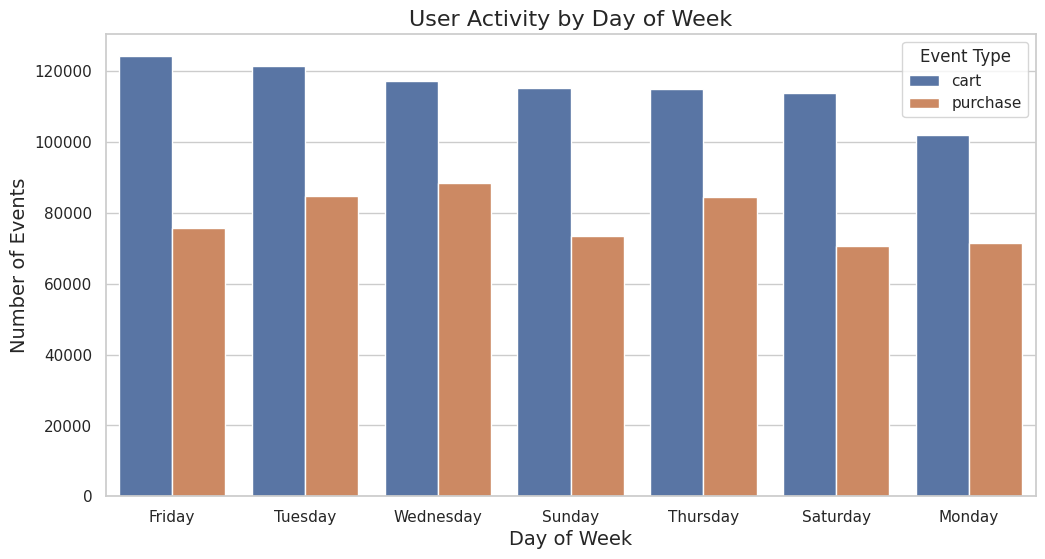

In [34]:
daily_activity_filtered=daily_activity.filter(col('event_type') != 'view')
daily_filtered_pd=daily_activity_filtered.toPandas()

day_mapping = {
    1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday",
    5: "Thursday", 6: "Friday", 7: "Saturday"
}
daily_filtered_pd["day_name"] = daily_filtered_pd["event_day"].map(day_mapping)

plt.figure(figsize=(12,6))
sns.barplot(data=daily_filtered_pd, x="day_name", y="event_day_cnt", hue="event_type")
plt.title("User Activity by Day of Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=14)
plt.ylabel("Number of Events", fontsize=14)
plt.legend(title="Event Type")
plt.show()

In [ ]:
df_ecom_part.select('product_id').distinct().count()

In [ ]:
df_ratings = df_ecom_part.withColumn('item_id',concat_ws('_',col('category_code'),col('brand')))
df_ratings = df_ratings.withColumn('ratings',when(col('event_type')=='view',1) \
                                            .when(col('event_type')=='cart',3) \
                                            .when(col('event_type')=='purchase',5)) \
                        .select('user_id','item_id','ratings')
df_ratings.show(5,False)

In [ ]:
item_indexer = StringIndexer(inputCol="item_id", outputCol="item_id_index")
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_id_index")

# Fit and transform
df_ratings = item_indexer.fit(df_ratings).transform(df_ratings)
df_ratings = user_indexer.fit(df_ratings).transform(df_ratings)

df_ratings.show(5)

In [ ]:
ratings_sampled = df_ratings.sample(fraction=0.1, seed=42)
(training, test) = ratings_sampled.randomSplit([0.8, 0.2], seed=42)

als = ALS(
    userCol="user_id_index",
    itemCol="item_id_index",
    ratingCol="ratings",
    implicitPrefs=True,
    coldStartStrategy="drop",
    rank=10,
    maxIter=10,
    regParam=0.1
)

model=als.fit(training)
user_recommendations = model.recommendForAllUsers(5)
user_recommendations.show(5)

recommendations_flat = user_recommendations.withColumn("rec", explode("recommendations")) \
    .select(
        "user_id",
        col("rec.item_id").alias("item_id"),
        col("rec.ratings").alias("predicted_rating")
    )

recommendations_flat.show(5)

# Segmentation

In [35]:
User segmentation using K-Means

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col

# Step 1: Use your existing user_behavior DataFrame
# If not already defined, create it as below:
user_behavior = df_ecom_part.groupBy("user_id").agg(
    count(when(col("event_type") == "view", 1)).alias("view_count"),
    count(when(col("event_type") == "cart", 1)).alias("cart_count"),
    count(when(col("event_type") == "purchase", 1)).alias("purchase_count")
).withColumn(
    "total_events", col("view_count") + col("cart_count") + col("purchase_count")
).withColumn(
    "purchase_ratio", expr("purchase_count / total_events")
).na.fill(0)  # fill NaNs if total_events is 0

# Step 2: Assemble feature vector
feature_cols = ["view_count", "cart_count", "purchase_count", "purchase_ratio"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(user_behavior)

# Step 3: Apply KMeans clustering (k=3 for 3 segments)
kmeans = KMeans(k=3, seed=42, featuresCol="features", predictionCol="segment_cluster")
kmeans_model = kmeans.fit(df_features)

df_clustered = kmeans_model.transform(df_features)

# Step 4: Evaluate clustering (optional)
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="segment_cluster")
silhouette = evaluator.evaluate(df_clustered)
print(f"\nSilhouette score: {silhouette:.3f}")

# Step 5: Show clustered user segments
df_clustered.select("user_id", "view_count", "cart_count", "purchase_count", "purchase_ratio", "segment_cluster") \
            .withColumn(
                            "segment_label",
                            when(col("segment_cluster") == 0, "High_Intent")
                            .when(col("segment_cluster") == 1, "Medium_Intent")
                            .when(col("segment_cluster") == 2, "Low_Intent")
                            .otherwise("Unknown")
                        ) \
            .orderBy(col('purchase_ratio').desc()) \
            .show(truncate=False)

SyntaxError: invalid syntax (2327259534.py, line 1)